<img src= "https://rapids.ai/assets/images/RAPIDS-logo-white.svg" alt ="RAPIDS" style='width: 800px;'>

## Rapids for faster processing

**RAPIDS** is a collection of GPU-accelerated machine learning libraries that will provide GPU versions of machine learning algorithms. **cuML** is one such library. cuML provides a suite of fast, GPU-accelerated machine learning algorithms designed for data science and analytical tasks.

***In order to use cuML in your kaggle notebook just make sure your GPU environment is on. No further installations are required.***

Do refer to the [towards data science](https://towardsdatascience.com/train-your-machine-learning-model-150x-faster-with-cuml-69d0768a047a) article by Khuyen Tran.

### Import the libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import gc
import transformers
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from transformers import BertModel
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

### Configuration Class

In [ ]:
class CFG:
    max_len = 64
    model_name = '../input/bertforpatents/bert-for-patents'
    batch_size = 32
    device = 'cuda'

### Read the data

The dataset contains three features.
* Anchor text
* Target text
* Context code

Relace context code with the actual context text using the Cooperative Patent Classification Codes dataset. This dataset has the mapping of codes to the context. For instance **A01** could refer to any of **AGRICULTURE, FORESTRY, ANIMAL HUSBANDRY, HUNTING, TRAPPING, FISHING**.

In [ ]:
train=pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv')
test=pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv')
submission=pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv')

In [ ]:
cpc_codes = pd.read_csv("/kaggle/input/cpc-codes/titles.csv")
cpc_codes = cpc_codes.rename(columns = {"code" : "context"})
cpc_codes

In [ ]:
train_data=pd.merge(train,cpc_codes[["context","title"]],on="context",how="left")
test_data=pd.merge(test,cpc_codes[["context","title"]],on="context",how="left")

In [ ]:
train_data.head()

In [ ]:
train_data["title"]=train_data["title"].apply(lambda x:re.sub('[;,]','',x))
test_data["title"]=test_data["title"].apply(lambda x:re.sub('[;,]','',x))

In [ ]:
#combine the phrases into a single sentence.
train_data['text']=train_data['anchor']+'[SEP]'+train_data['target']+'[SEP]'+train_data['title']
test_data['text']=test_data['anchor']+'[SEP]'+test_data['target']+'[SEP]'+test_data['title']

### Model Architecture

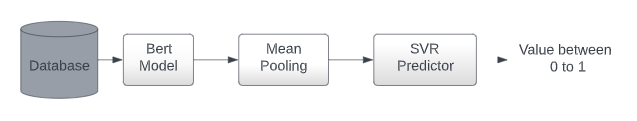

* **Embedding model** -> Bert large (1024 embed dimension).
* **Mean pooling** -> Convert the output of Bert (B, W, D) into a one dimensional vector (B, D).
* **Predictor model** -> Support Vector Regressor (Features count : 1024)

Here D = 1024

In [ ]:
class EmbedModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        self.model = BertModel.from_pretrained(model_name, return_dict=False)

    def forward(self, input_ids, attn_mask):
        return self.model(input_ids, attn_mask)[0]

In [ ]:
'''
Takes in text and tokenizer and converts the text to tokens 
which could be fed into the bert model to get the embeddings.
'''
def create_data(id_,train_data,tokenizer,train=True):
    input_ids=[]
    attention_mask=[]
    labels=[]
    ids=[]
    tok_text=tokenizer.batch_encode_plus(list(train_data['text']),
                                        max_length=CFG.max_len,
                                        padding='max_length',
                                        truncation=True)
    for i in range(len(train_data)):
        ids.append(id_[i])
        input_ids.append(tok_text['input_ids'][i])
        attention_mask.append(tok_text['attention_mask'][i])
        if train:
            labels.append(train_data['score'][i])
    return {"input_ids":input_ids,
           "attention_mask":attention_mask,
           "ids":ids,
           "labels":labels}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

#create the train and test tokens.
train_data = create_data(list(train_data['id']), train_data, tokenizer, train=True)
test_data = create_data(list(test_data['id']), test_data, tokenizer, train=False)

### Dataset for Bert

In [ ]:
#Dataset pipeline for Bert model.
class PhraseDataset(Dataset):

  def __init__(self, dataset):
    self.ids = dataset['ids']
    self.text_ids = dataset['input_ids']
    self.text_attns = dataset['attention_mask']
    self.scores = dataset['labels']

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, index):
    text_id = self.text_ids[index]
    text_attn = self.text_attns[index]
    score = torch.tensor(self.scores[index], dtype=torch.float32)
    return np.array(text_id), np.array(text_attn), score

class PhraseTestDataset(Dataset):

  def __init__(self, dataset):
    self.ids = dataset['ids']
    self.text_ids = dataset['input_ids']
    self.text_attns = dataset['attention_mask']
    self.scores = dataset['labels']

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, index):
    text_id = self.text_ids[index]
    text_attn = self.text_attns[index]
    return np.array(text_id), np.array(text_attn)

In [ ]:
columns = []
for i in range(1024):
    columns.append('feature_{}'.format(i))
columns += ['label']

### Generate features usng Bert

In [ ]:
'''
Function that takes in model and data loader as parameters
Returns a dataframe with 1025 columns (1024 features as output of Bert and 1 label)
'''
def gen_feats(model, dataloader):
    datas = []
    model.eval()
    for i, batch in tqdm(enumerate(dataloader)):
        input_ids = batch[0].to('cuda', non_blocking=True)
        attn_mask = batch[1].to('cuda', non_blocking=True)
        label = batch[2].tolist()
        embed = model(input_ids, attn_mask)
        embed = torch.sum(embed, 1)/embed.shape[1]
        embed = embed.detach().cpu().numpy().tolist()
        datas += [embed[j] + [label[j]] for j in range(len(label))]
        del input_ids, attn_mask, label, embed
        gc.collect()
        torch.cuda.empty_cache()
    return pd.DataFrame(datas, columns=columns)

'''
Function that takes in model and data loader as parameters
Returns a dataframe with 1024 columns (1024 features as output of Bert)
'''
def gen_test_feats(model, dataloader):
    datas = []
    model.eval()
    for i, batch in tqdm(enumerate(dataloader)):
        input_ids = batch[0].to('cuda', non_blocking=True)
        attn_mask = batch[1].to('cuda', non_blocking=True)
        embed = model(input_ids, attn_mask)
        embed = torch.sum(embed, 1)/embed.shape[1]
        embed = embed.detach().cpu().numpy().tolist()
        datas += embed
        del input_ids, attn_mask, embed
        gc.collect()
        torch.cuda.empty_cache()
    return pd.DataFrame(datas, columns=columns[:-1])

In [ ]:
train_dataset = PhraseDataset(train_data)
test_dataset = PhraseTestDataset(test_data)

model = EmbedModel(CFG.model_name)
model.to(CFG.device)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=CFG.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=CFG.batch_size)

In [ ]:
train_feats = gen_feats(model, train_dataloader)
train_feats.head()

In [ ]:
test_feats = gen_test_feats(model, test_dataloader)
test_feats.head()

### Support Vector Regressor

It becomes impossible to train the sklearn SVR when the dataset size is as big as 10000. cuML library comes to the rescue by speeding up the training process by almost 100 times. Below is the implementation of the SVR using cuML library.

SVM has two important parameters namely C and gamma, that have to be tuned in order to get the best possible accuracy. Understanding how SVM orks in general will halp a lot when it comes to hyperparameter tuning. In order to understand how SVM works refer to [Stat Quest Series](https://www.youtube.com/watch?v=efR1C6CvhmE).

In [ ]:
from cuml.svm import SVR

svr = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1) #10 0.1
train_labels = train_feats.label.values
tr_ready = train_feats.drop('label', axis=1)
svr.fit(tr_ready, train_labels)

In [ ]:
y_pred = svr.predict(test_feats)

In [ ]:
sub_data = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/sample_submission.csv')
sub_data['score'] = y_pred

In [ ]:
sub_data.head()

In [ ]:
sub_data.to_csv('submission.csv',index=False)

#### Thanks for being there till the end! Consider upvoting if you have liked the notebook.